In [33]:
import matplotlib.pyplot as plt
from riskyneuroarousal.utils.load_data import load_behavioral_data
from scipy.stats import false_discovery_control

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


##### Load the data
Remove RT outliers (defined as any response time less than 0.2 seconds). This also eliminates the trials where the subject did not respond.

In [3]:
data = load_behavioral_data(min_RT = 0.2)

In [41]:
# uncertain is 1 when response int is 2 or 3, 0 otherwise
data['uncertain'] = data["response_int"].apply(lambda x: "Yes" if x == 2 or x == 3 else "No")

### Analysis of response time
**Question: Association of Gain and Loss on Response Time. Differences between conditions**

In [42]:
%%R -i data
library(lme4)
library(lmerTest)
library(broom.mixed)

In [59]:
%%R
# This is the maximal model that converged
model1 <- lmer(RT ~ condition*gain + condition*loss + condition*uncertain + (1|sub), data=data)
summary(model1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ condition * gain + condition * loss + condition * uncertain +  
    (1 | sub)
   Data: data

REML criterion at convergence: 38297.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9526 -0.6594 -0.1703  0.4904  5.7562 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.08779  0.2963  
 Residual             0.23159  0.4812  
Number of obs: 27443, groups:  sub, 108

Fixed effects:
                                   Estimate Std. Error         df t value
(Intercept)                       1.425e+00  4.359e-02  1.418e+02  32.697
conditionequalRange              -5.161e-02  6.169e-02  1.421e+02  -0.837
gain                             -3.276e-03  4.491e-04  2.733e+04  -7.294
loss                              1.457e-02  9.023e-04  2.733e+04  16.147
uncertainYes                      4.331e-01  9.159e-03  2.739e+04  47.291
conditionequalRange:gain     

From this, we know that there is a significant difference in how gains, loss, and uncertainty influence the response time per condition. Now lets run a post-hoc analysis to determine the parameters for each condition. 

In [47]:
%%R
modelIndifference <- lmer(RT ~ gain + loss + uncertain + (1|sub), data=data[data$condition == 'equalIndifference', ])
modelRange <- lmer(RT ~ gain + loss + uncertain + (1|sub), data=data[data$condition == 'equalRange', ])

In [48]:
%%R -o results
resultsIndifference <- tidy(modelIndifference, effects = "fixed", conf.int = TRUE, conf.level = 0.95) 
resultsRange <- tidy(modelRange, effects = "fixed", conf.int = TRUE, conf.level = 0.95)
resultsIndifference$condition <- 'equalIndifference'
resultsRange$condition <- 'equalRange'
results <- rbind(resultsIndifference, resultsRange)

In [50]:
results["p.value"]= false_discovery_control(results["p.value"].values, method="by")
results["significant"] = results["p.value"] < 0.05
results = results.rename(columns={"estimate": "Odds Ratio", "conf.low": "2.5%", "conf.high": "97.5%"})
names = []
for idx, row in results.iterrows():
    if row.term == "(Intercept)":
        names.append(f"Intercept: {row.condition}")
    elif row.term == "gain":
        names.append(f"Gain: {row.condition}")
    elif row.term == "loss":
        names.append(f"Loss: {row.condition}")
    elif row.term == "uncertainYes":
        names.append(f"Uncertain: {row.condition}")
results["term"] = names

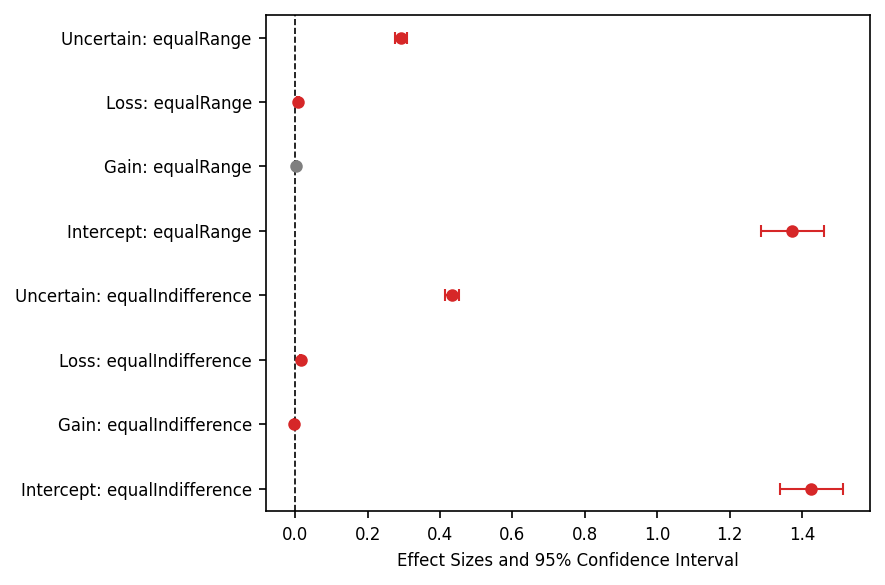

In [55]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)
for idx, row in results.iterrows():
    ci = [[row['Odds Ratio'] - row[::-1]['2.5%']], [row['97.5%'] - row['Odds Ratio']]]
    if row['significant']:
        plt.errorbar(x=[row['Odds Ratio']], y=[row.term], xerr=ci,
            ecolor='tab:red', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:red", mec="tab:red")
    else:
        plt.errorbar(x=[row['Odds Ratio']], y=[row.term], xerr=ci,
            ecolor='tab:gray', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:gray", mec="tab:gray")
plt.axvline(x=0, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Effect Sizes and 95% Confidence Interval', fontsize=8)
plt.tight_layout()